In [1]:
def covid_rdd(path_to_csv, cutoff_date, cutoff_days):

    # Import Necessary Libraries
    import datetime as dt
    from datetime import timedelta
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    import matplotlib.dates as mdates
    import statsmodels.api as sm

    # Convert cutoff_date to DATE data type.
    cutoff_date = pd.to_datetime(cutoff_date, format='%d/%m/%Y')
    
    # Column names of CSV file.
    column_names = ['Date', 'Nb_Cas_Cumulatif', 'Nb_Nvx_Cas', 'Nb_Deces_Cumulatif_Total', 'Nb_Deces_Cumulatif_CHCHSLD', 'Nb_Deces_Cumulatif_RPA', 'Nb_Deces_Cumulatif_DomInc', 'Nb_Deces_Cumulatif_Autre', 'Nb_Nvx_Deces_Total', 'Nb_Nvx_Deces_CHCHSLD', 'Nb_Nvx_Deces_RPA', 'Nb_Nvx_Deces_DomInc', 'Nb_Nvx_Deces_Autre']
    
    # Load CSV file, and convert data types.
    df = pd.read_csv(path_to_csv, skiprows=2, names=column_names)
    df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')
    df = df.sort_values(by='Date')

    # Transform columns, and Filter data.
    df_filtered = df[['Date', 'Nb_Nvx_Cas']].copy()
    df_filtered['Diff_Cutoff_Date'] = ((df_filtered['Date'] - cutoff_date) / np.timedelta64(1, 'D')).astype('int64')
    df_filtered = df_filtered.loc[abs(df_filtered['Diff_Cutoff_Date']) <= cutoff_days]
    df_filtered['Gregorian_Ordinal'] = df_filtered['Date'].apply(pd.Timestamp.toordinal)
    df_filtered = df_filtered.reset_index(drop=True)
    
    # Create dataframe with data before cutoff date.
    df_before_cutoff = df_filtered.loc[df_filtered['Diff_Cutoff_Date'] <= 0].copy()
    df_before_cutoff = df_before_cutoff.drop(['Diff_Cutoff_Date'], axis=1)
    df_before_cutoff = df_before_cutoff.reset_index(drop=True)
    
    # Create Model for data before cutoff date.
    x_before_cutoff = df_before_cutoff[['Gregorian_Ordinal']]
    x_before_cutoff = sm.add_constant(x_before_cutoff)
    y_before_cutoff = df_before_cutoff['Nb_Nvx_Cas']
    model_before_cutoff = sm.OLS(y_before_cutoff, x_before_cutoff).fit()
    # Predict Nb_Nvx_Cas after cutoff date.
    y_fit_before_cutoff = model_before_cutoff.predict(x_before_cutoff)
    df_before_cutoff['Nb_Nvx_Cas_Predicted'] = y_fit_before_cutoff
    
    # Create dataframe with data after cutoff date.
    df_after_cutoff = df_filtered.loc[df_filtered['Diff_Cutoff_Date'] >= 0].copy()
    df_after_cutoff = df_after_cutoff.drop(['Diff_Cutoff_Date'], axis=1)
    df_after_cutoff = df_after_cutoff.reset_index(drop=True)
    # Create Model for data after cutoff date.    
    x_after_cutoff = df_after_cutoff['Gregorian_Ordinal']
    x_after_cutoff = sm.add_constant(x_after_cutoff)
    y_after_cutoff = df_after_cutoff['Nb_Nvx_Cas']
    model_after_cutoff = sm.OLS(y_after_cutoff, x_after_cutoff).fit()
    # Predict Nb_Nvx_Cas after cutoff date.
    y_fit_after_cutoff = model_after_cutoff.predict(x_after_cutoff)
    df_after_cutoff['Nb_Nvx_Cas_Predicted'] = y_fit_after_cutoff
    
    # Create dataframe with data needed to plot line between regression lines.
    df_cutoff = pd.concat([df_before_cutoff.tail(1), df_after_cutoff.head(1)], axis="rows").reset_index(drop=True)
    
    # Plot graph.
    fig, ax = plt.subplots(figsize=(12,7))
    # Plot vertical line at cutoff date.
    ax.vlines(cutoff_date, 0, max(df_after_cutoff['Nb_Nvx_Cas']) * 1.05, color='black', linewidth=0.5, linestyle='dotted')
    # Plot scatter plot and regression line for data before cutoff date.
    ax.scatter(df_before_cutoff['Date'], df_before_cutoff['Nb_Nvx_Cas'], color='#2094FA')
    ax.plot(df_before_cutoff['Date'], df_before_cutoff['Nb_Nvx_Cas_Predicted'], color='#FA114F')
    # Plot scatter plot and regression line for data after cutoff date.
    ax.scatter(df_after_cutoff['Date'], df_after_cutoff['Nb_Nvx_Cas'], color='#04DE71')
    ax.plot(df_after_cutoff['Date'], df_after_cutoff['Nb_Nvx_Cas_Predicted'], color='#FA114F')
    # Plot line between regression lines.
    ax.plot(df_cutoff['Date'], df_cutoff['Nb_Nvx_Cas_Predicted'], color='#FA114F', linestyle='dashed')
    # Modify look and feel of the graph.
    ax.grid(True, color='#E5E5EA', linewidth = 0.5)
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=7))
    ax.set_xlim(min(df_filtered['Date']) - timedelta(days=2), max(df_filtered['Date']) + timedelta(days=2))
    ax.set_ylim(0, max(df_filtered['Nb_Nvx_Cas']) * 1.05)
    ax.set_xlabel('Date')
    ax.set_ylabel('Nb_Nvx_Cas')
    fig.autofmt_xdate()
    fig.tight_layout()
    
    
    print(model_before_cutoff.summary())
    print(model_after_cutoff.summary())

                            OLS Regression Results                            
Dep. Variable:             Nb_Nvx_Cas   R-squared:                       0.417
Model:                            OLS   Adj. R-squared:                  0.372
Method:                 Least Squares   F-statistic:                     9.307
Date:                Thu, 12 Jan 2023   Prob (F-statistic):            0.00929
Time:                        21:46:42   Log-Likelihood:                -62.850
No. Observations:                  15   AIC:                             129.7
Df Residuals:                      13   BIC:                             131.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const             -2.307e+06   7.56e+0

C:\Users\Aley\anaconda3\lib\site-packages\scipy\stats\_stats_py.py:1769: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=15
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\Aley\anaconda3\lib\site-packages\scipy\stats\_stats_py.py:1769: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=15
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


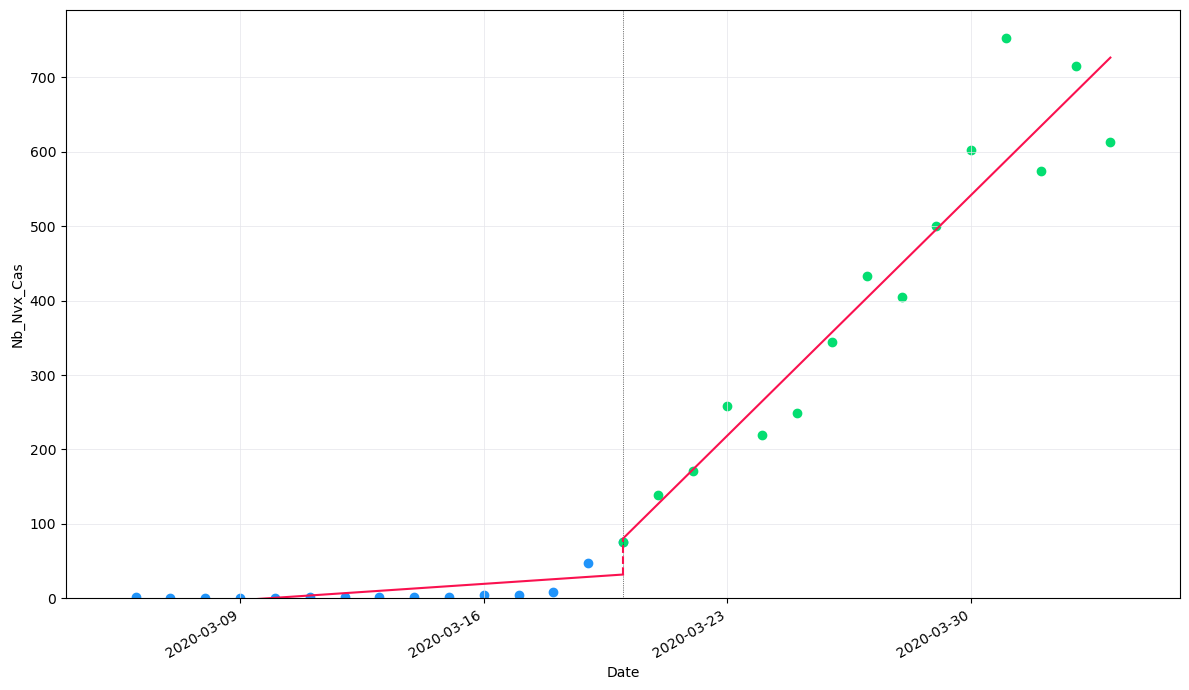

In [2]:
# The 20/3/2020 lockdown
covid_rdd('data/COVID19_Qc_RapportINSPQ_HistoVigie.csv', '20/03/2020', 14)

For the first lockdown event, the best time period to choose was 2 weeks. It was not until March 11th 2020 covid cases in Quebec were being reported. This could be explained by the virus’ incubation period: it takes time for an infected person to show symptoms and get an accurate covid test result. A huge spike in new covid cases started to emerge a few days before the first lockdown. Through trial and error, time periods greater than 2 weeks resulted in poor regression results, specifically for the first half of the regression. Consequently, the plot did not accurately describe the fast rise of new cases during the days leading to the lockdown.  

The linear regression model chosen for this task was a model with an added constant term and without any polynomial features for the following reasons. Without a constant term, the regression lines did not fit data best. When implementing a polynomial feature, model metrics indicated heavy overfitness: AIC and BIC values were lower and R2 scores got closer to 1 when compared to the chosen model. More precisely, using a polynomial feature in the model almost doubled the R2 score  for the period before lockdown, a major sign of overfitness. To test the effect of the cutoff parameter on data, a t-test was performed using 2 population samples: before and after the cutoff event. The test produced a pvalue of 0.025. Being less than 0.05, the null hypothesis (cutoff parameter has no effect on output) is rejected and it proves the cutoff parameters statistical significance.

                            OLS Regression Results                            
Dep. Variable:             Nb_Nvx_Cas   R-squared:                       0.057
Model:                            OLS   Adj. R-squared:                  0.046
Method:                 Least Squares   F-statistic:                     5.334
Date:                Thu, 12 Jan 2023   Prob (F-statistic):             0.0232
Time:                        21:46:42   Log-Likelihood:                -472.06
No. Observations:                  91   AIC:                             948.1
Df Residuals:                      89   BIC:                             953.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const              2.979e+05   1.29e+0

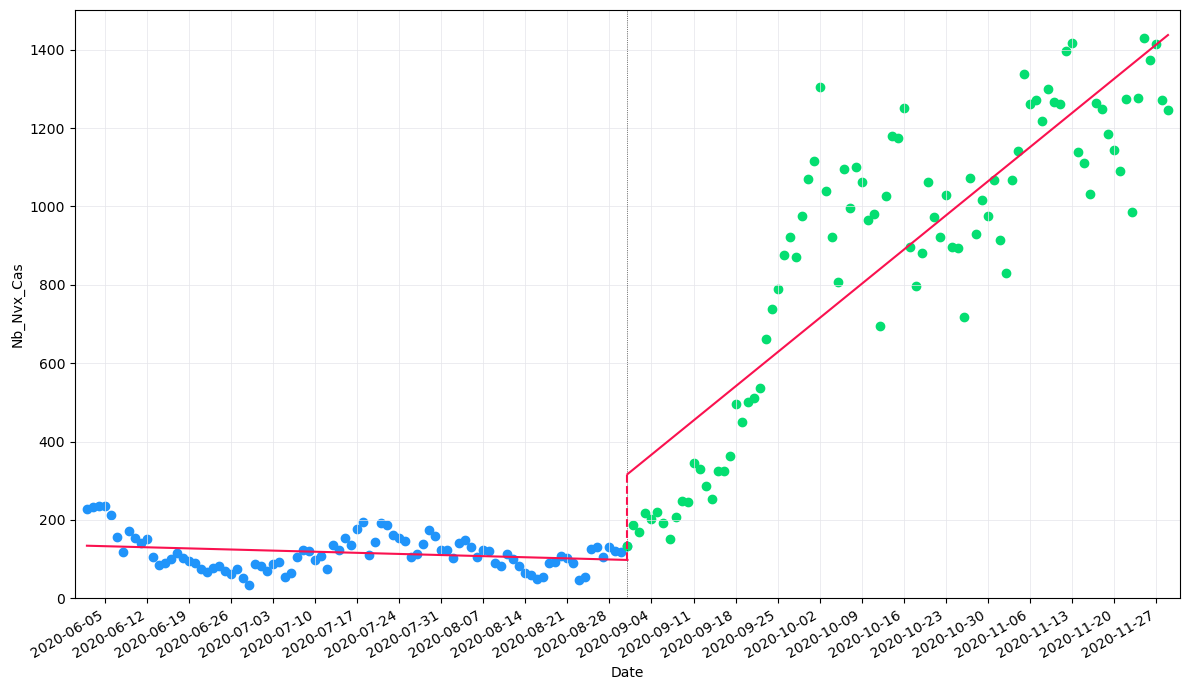

In [3]:
# The reopening of schools on 31/8/2020
covid_rdd('data/COVID19_Qc_RapportINSPQ_HistoVigie.csv', '31/08/2020', 90)

Before cutoff model:  

This summary is for the linear regression model that looks at predicting the number of cases based on the days since cutoff. The model is statistically significant and the independent variable "Days_since_cutoff" has a negative effect on the number of cases, as supported by the p-value and t-value. The R-squared value of 0.062 suggests that the independent variable explains about 6.2% of the variability in the dependent variable. The normality of the residuals is verified by the Omnibus and JB tests, which also support that the model is appropriate. Overall, this model suggests that the number of cases decreases as the days since cutoff increases. In simpler words, for the before model, we can see that the number of cases decrease as covid measures are still going strong and the schools have not reopened yet.  

After cutoff model:  

This model is similar to the previous in that it also tries to predict the number of cases since the cutoff event. This model is extremely statistically significant with a p-value of 2.69e-28 (close to zero or almost zero) and the independent variable "Days_since_cutoff" has a positive effect on the number of cases, as supported by the t-value. The R-squared value of 0.747 suggests that the independent variable explains about 74.7% of the variability in the dependent variable. The adjusted R-squared value is 0.744 which is very close to R-squared value. The normality of the residuals is verified by the Omnibus and JB tests, which also support that the model is appropriate. Overall, this model suggests that the number of cases increases as the days since cutoff increases. In simpler words, as schools reopen and more people are interacting, the number of cases increase as we move further from the cutoff date. Moral of the story: don't go to school. Be a hero: stay home and save lives.

                            OLS Regression Results                            
Dep. Variable:             Nb_Nvx_Cas   R-squared:                       0.723
Model:                            OLS   Adj. R-squared:                  0.720
Method:                 Least Squares   F-statistic:                     232.1
Date:                Thu, 12 Jan 2023   Prob (F-statistic):           1.57e-26
Time:                        21:46:43   Log-Likelihood:                -620.30
No. Observations:                  91   AIC:                             1245.
Df Residuals:                      89   BIC:                             1250.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const             -1.002e+07   6.58e+0

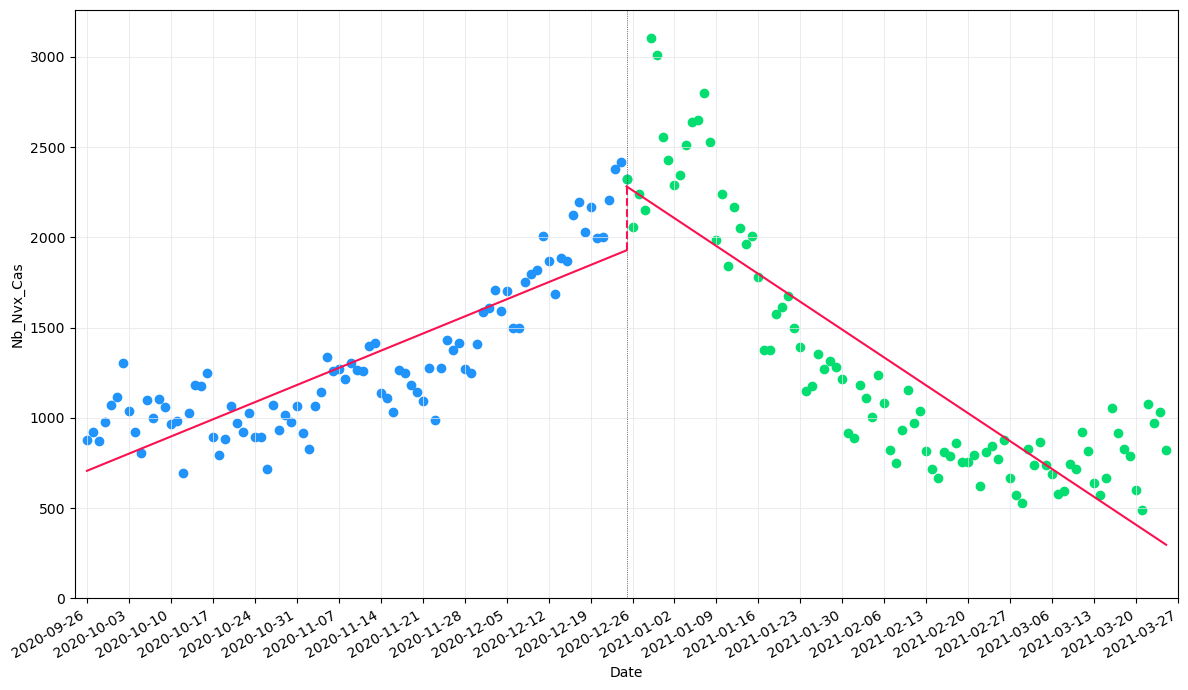

In [4]:
# The 25/12/2020 lockdown
covid_rdd('data/COVID19_Qc_RapportINSPQ_HistoVigie.csv', '25/12/2020', 90)

The first linear model aims to predict the number of cases based on the days since the cutoff event of the second lockdown. The model is statistically significant and the independent variable "Gregorian_Ordinal" has a positive effect on the number of cases, as supported by the p-value and t-value. The R-squared value of 0.723 suggests that the independent variable explains about 72.3% of the variability in the dependent variable. As we were still experiencing the positive increase in cases following the reopening of schools, the number got higer as we approached the implementation of the second lockdown.

The second model is also a linear regression model that also aims to predict the number of cases. The model is  statistically significant and the independent variable "Gregorian_Ordinal" has a negative effect on the number of cases, as supported by the p-value and t-value. The R-squared value of 0.734 suggests that the independent variable explains about 73.4% of the variability in the dependent variable. The positive effects of the lockdown on slowing the spread of the virus ensured a net drop in daily new cases.

The difference between the two models is the direction and magnitude of effect of the independent variable on the dependent variable.